In [154]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
import matplotlib.image as img

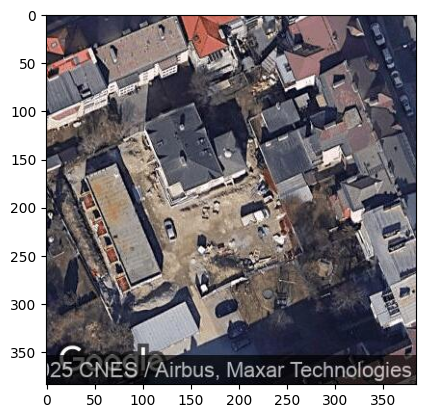

In [197]:
test_image = cv2.imread('map_image.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = resize(test_image,(384,384,3))
plt.imshow(test_image, cmap='gray')
plt.show()

In [198]:
test_image.shape

(384, 384, 3)

In [156]:
model_path = './models/model_85.keras'
model = tf.keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


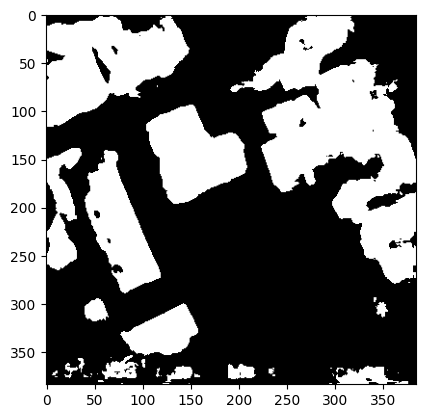

In [205]:
mask = model.predict(np.expand_dims(test_image, 0))
mask= mask.reshape(384,384)*255
ret, pred = cv2.threshold(mask, 125, 255, cv2.THRESH_BINARY)
plt.imshow(pred, cmap='gray')
    

In [209]:
def create_aggregated_mask(image, threshold_value, kernel_size, flood_fill=False):
    # Convert the image to grayscale
    gray =image

    # Apply binary threshold to create the initial mask
    _, binary_mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    # Create a kernel for morphological operations
    kernel = np.zeros((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing operation to fill small holes and aggregate mask
    aggregated_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    if flood_fill:
        # Create a mask for flood filling with a border of 2 pixels
        flood_fill_mask = np.zeros((aggregated_mask.shape[0] + 2, aggregated_mask.shape[1] + 2), np.uint8)

        # Flood fill the mask starting from a seed point
        cv2.floodFill(aggregated_mask, flood_fill_mask, (0, 0), 255)

        # Invert the flood-filled mask
        inverted_flood_fill = cv2.bitwise_not(flood_fill_mask[1:-1, 1:-1])

        # Ensure the dimensions match before combining
        aggregated_mask = cv2.resize(aggregated_mask, (inverted_flood_fill.shape[1], inverted_flood_fill.shape[0]))

        # Combine the aggregated mask with the flood-filled mask
        aggregated_mask = cv2.bitwise_or(aggregated_mask, inverted_flood_fill)

    return aggregated_mask

# Example usage
image = cv2.imread('path/to/image.jpg')
threshold_value = 125
kernel_size = 5
flood_fill = True

mask = create_aggregated_mask(mask, threshold_value, kernel_size, flood_fill)
cv2.imwrite('aggregated_mask.png', mask)


[ WARN:0@272193.221] global loadsave.cpp:268 findDecoder imread_('path/to/image.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


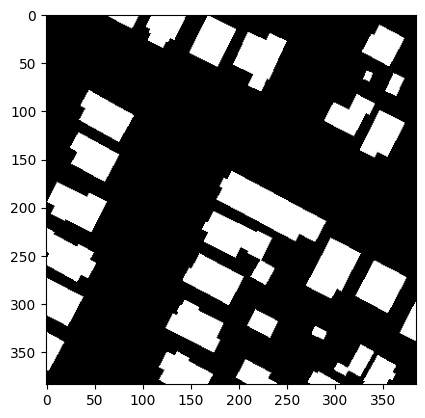

In [180]:
from skimage.color import rgb2gray
gt = cv2.imread('./AerialImageDataset/train_384x384/gt/austin20_1_1.png')
gt = resize(gt,(384,384,3))

gt = rgb2gray(gt)
plt.imshow(gt, cmap='gray')
plt.show()

In [181]:
intersection = np.logical_and(gt, pred)
union = np.logical_or(gt, pred)
iou_score = np.sum(intersection) / np.sum(union)

In [182]:
iou_score

np.float64(0.8234401668879195)

In [ ]:
# Load the binary mask image
binary_mask = pred

# Check if the binary mask image is loaded correctly
if binary_mask is None:
    raise ValueError("Binary mask image not found at the specified path.")

# Convert binary mask to CV_8UC1 format
binary_mask = (binary_mask * 255).astype(np.uint8)

# Find contours of the white pixels
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Load the original image (assuming the same size as the binary mask)
original_image_path ='map_image.jpg'
original_image = cv2.imread(original_image_path)
# original_image = resize(original_image,(384,384,3))

# Check if the original image is loaded correctly
if original_image is None:
    raise ValueError("Original image not found at the specified path.") 

# Ensure the original image is in the correct format for display
if len(original_image.shape) == 2:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# Draw polygons around the detected contours and calculate areas
for contour in contours:
    # Approximate the contour to reduce the number of points
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(original_image, [approx], -1, (0, 255, 0), 1)
    
    # Calculate the area in pixel units
    pixel_area = cv2.contourArea(contour)

    
    # Print or store the area values as needed
    print(f"Pixel Area: {pixel_area}")

# Save the image with traced rooftops
output_path = '_output_image.png'
cv2.imwrite(output_path, original_image)

# Optionally, display the image with traced rooftops
# cv2.imshow('Detected Rooftops', original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 4.5
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 2.0
Pixel Area: 3.0
Pixel Area: 0.0
Pixel Area: 9.0
Pixel Area: 0.0
Pixel Area: 0.5
Pixel Area: 0.0
Pixel Area: 9.0
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 6.5
Pixel Area: 0.0
Pixel Area: 18.5
Pixel Area: 10.0
Pixel Area: 674.5
Pixel Area: 232.5
Pixel Area: 305.0
Pixel Area: 52.0
Pixel Area: 17.5
Pixel Area: 32.5
Pixel Area: 0.0
Pixel Area: 487.5
Pixel Area: 2513.5
Pixel Area: 96.5
Pixel Area: 385.0
Pixel Area: 6.5
Pixel Area: 0.0
Pixel Area: 3.5
Pixel Area: 0.0
Pixel Area: 1.5
Pixel Area: 5486.5
Pixel Area: 2426.5
Pixel Area: 6471.0
Pixel Area: 0.0
Pixel Area: 0.0
Pixel Area: 3.0
Pixel Area: 0.0
Pixel Area: 10586.5
Pixel Area: 22679.5
Pixel Area: 12.0
Pixel Area: 0.0


True

In [47]:
image_path = 'AerialImageDataset/train_384x384/images/austin9_9_3.jpg'

In [48]:
draw_bounding_boxes(image_path=image_path, output_path='./')

NameError: name 'draw_bounding_boxes' is not defined